In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы

In [2]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [3]:
data = pd.read_csv('credit_scoring_sample.csv', sep=';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


### Прогнозируемая переменная

SeriousDlqin2yrs – Человек не выплатил данный кредит в течение 90 дней; возможные значения 1/0

### Независимые признаки

age – Возраст заёмщика кредитных средств; тип - integer

NumberOfTime30-59DaysPastDueNotWorse – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип - integer

DebtRatio – Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.) / совокупный месячный доход percentage; тип - real

MonthlyIncome – Месячный доход в долларах; тип - real

NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип - integer

NumberOfTime60-89DaysPastDueNotWorse – Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип - integer

NumberOfDependents – Число человек в семье кредитозаёмщика; тип - integer

In [4]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение классов в зависимой переменной

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

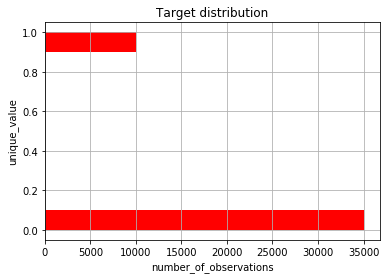

In [5]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [6]:
table = fill_nan(data)

In [7]:
X = table.drop('SeriousDlqin2yrs', axis=1)
y = table.loc[:, 'SeriousDlqin2yrs']
X.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,64,0,0.249908,0,0,8158.0,0.0
1,58,0,3870.000000,0,0,5166.0,0.0
2,41,0,0.456127,0,0,6666.0,0.0
3,43,0,0.000190,0,0,10500.0,2.0
4,49,0,0.271820,0,0,400.0,0.0


In [8]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: SeriousDlqin2yrs, dtype: int64

## Бутстрэп

Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте np.random.seed(0), как это сделано в статье.

In [9]:
def get_bootstrap_samples(data, n_samples):
    indexes = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indexes]
    return samples

In [10]:
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [11]:
np.random.seed(0)

class1_values = X[np.array(y) == 1]['age'].values
class0_values = X[np.array(y) == 0]['age'].values

In [12]:
class1_scores = [np.mean(sample) for sample in get_bootstrap_samples(class1_values, 1000)]
class0_scores = [np.mean(sample) for sample in get_bootstrap_samples(class0_values, 1000)]

In [13]:
print("Class 1:  mean interval",  stat_intervals(class1_scores, 0.1))
print("Class 0:  mean interval",  stat_intervals(class0_scores, 0.1))

Class 1:  mean interval [45.71379414 46.12700479]
Class 0:  mean interval [52.59470132 52.85480064]


### Подбор параметров для модели логистической регрессии

Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0 до 1. Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [15]:
log_reg = LogisticRegression(solver='lbfgs')

Выберем параметры регуляризации

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
cv_log = GridSearchCV(estimator=log_reg, param_grid=parameters, cv=skf, scoring='roc_auc')

cv_log.fit(X, y)

c:\python\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\python\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\python\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\python\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\python\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\python\lib\site-packages\sklearn\linear_model\logistic.py:947:

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [17]:
cv_log.best_params_

{'C': 0.001}

In [18]:
cv_scores = []
for i in cv_log.cv_results_.keys():
    if 'split' in i :
        cv_scores.append(np.mean(cv_log.cv_results_[i]))
        print( np.mean(cv_log.cv_results_[i]))
best_score = np.max(cv_scores)
print('Best score: ', best_score)

0.7197699021466802
0.7073808652835187
0.721487703603842
0.6977166165979846
0.7339426041242927
Best score:  0.7339426041242927


## Определение влияния признаков

Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [67]:
log_reg = LogisticRegression(C=0.001, solver='lbfgs')
log_reg.fit(X_scaled, y)
influence = list(log_reg.coef_[0])
for i in range(len(influence)):
    influence[i] = abs(influence[i])   
influence

[0.3937298307740665,
 0.36916335656189636,
 0.021446158178740713,
 0.20530135896535298,
 0.07759228218661904,
 0.16622624993896865,
 0.11052229212977702]

Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией softmax)

In [75]:
import math
names = list(X.columns)

name_influence = {}
for i in range(len(influence)):
    name_influence[names[i]] = influence[i]
    
softmax_sum = 0

for i in name_influence:
    softmax_sum += math.exp(name_influence[i])

DebtRatio_softmax = np.exp(name_influence['DebtRatio']) / softmax_sum
DebtRatio_softmax

0.11939700290823983

## Случайный лес

In [79]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=8,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

rf_grid = GridSearchCV(rf_clf, parameters, cv=skf, n_jobs=8)
rf_grid.fit(X, y)
rf_best = rf_grid.best_estimator_